This Jupyter Notebook shows how the data presented in Figure 4, Extended Data Figure 10, and Supplementary Table 4 were generated. This is an experiment where DM-Seq was compared BS-Seq, head to head, using human glioblastoma tumor gDNA.

In [1]:
#packages
library(dplyr)
library(ggplot2)
library(tidyr)
library(VennDiagram)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: grid
Loading required package: futile.logger


# Figure 4A

Conversion efficiencies were directly obtained from the percent reads cytosine in the CpG context of the appropriate spike in. Their corresponding coverage files are provided on GEO. To calculate true positive detection rates, it was assumed that pUC19 and T4-hmC were 100% pure of CpGs and 5hmCpGs, respectively, so DM-Seq detection was determined by the percentage of bases sequencing as cytosine. For 5mCpGs, incomplete modification by M.SssI was taken into account and true positives = % T by DM-Seq / % C by BS-Seq = 95.8/96.9 = 98.9%.

# Figure 4B

In [2]:
# read in coverage files, can be downloaded from GEO
DM_coverage <- read.csv(file = "GBM_DM.txt",header=FALSE,
                       sep='\t')
BS_coverage <- read.csv(file = "GBM_BS.txt",header=FALSE,
                       sep='\t')

In [3]:
# put coverage files data in dataframe for easier manipulation
DM_cov_df <- tbl_df(DM_coverage)
BS_cov_df <- tbl_df(BS_coverage)

# rename column names
DM_cov_df <- DM_cov_df %>% rename(chr=V1)
DM_cov_df <- DM_cov_df %>% rename(start=V2)
DM_cov_df <- DM_cov_df %>% rename(end=V3)
DM_cov_df <- DM_cov_df %>% rename(perc_methyl=V4)

BS_cov_df <- BS_cov_df %>% rename(chr=V1)
BS_cov_df <- BS_cov_df %>% rename(start=V2)
BS_cov_df <- BS_cov_df %>% rename(end=V3)
BS_cov_df <- BS_cov_df %>% rename(perc_methyl=V4)

# add column that has what 1kb bin the CpG is in (by chromosome)
DM_cov_df <- DM_cov_df %>% group_by(chr) %>% mutate(bin_1000 = cut_interval(start, length=1000))
BS_cov_df <- BS_cov_df %>% group_by(chr) %>% mutate(bin_1000 = cut_interval(start, length=1000))

Warning message:
“`tbl_df()` was deprecated in dplyr 1.0.0.
Please use `tibble::as_tibble()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”

In [4]:
# create data frame with average percent cytosine for each 1kb bin by chromosome
# also summarize the coverage of each CpG in each 1kb bin
DM_bin_1000_mean_20b <- DM_cov_df %>% group_by(chr,bin_1000) %>% summarise(mean(perc_methyl),sum(V5+V6))
BS_bin_1000_mean_20b <- BS_cov_df %>% group_by(chr,bin_1000) %>% summarise(mean(perc_methyl),sum(V5+V6))

`summarise()` has grouped output by 'chr'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'chr'. You can override using the `.groups` argument.


In [5]:
# rename columns in summary dataframe
DM_bin_1000_mean_20b <- DM_bin_1000_mean_20b %>% rename(DM_coverage="sum(V5 + V6)")
BS_bin_1000_mean_20b <- BS_bin_1000_mean_20b %>% rename(BS_coverage="sum(V5 + V6)")

In [6]:
# remove all rows (aka 1kb bins) that have fewer than 20 CpGs covered
DM_bin_1000_mean_20b <- DM_bin_1000_mean_20b %>% filter(DM_coverage>=20)
BS_bin_1000_mean_20b <- BS_bin_1000_mean_20b %>% filter(BS_coverage>=20)

In [7]:
# join DM and BS average percent cytosine means by chromosome and bin
# use inner_join to only keep bins that are covered in both DM and BS
cor_data_1000_20b <- inner_join(DM_bin_1000_mean_20b,BS_bin_1000_mean_20b,by=c("chr","bin_1000"))

# rename columns to make sense
cor_data_1000_20b <- cor_data_1000_20b %>% rename(DM_mean="mean(perc_methyl).x")
cor_data_1000_20b <- cor_data_1000_20b %>% rename(BS_mean='mean(perc_methyl).y')

(polygon[GRID.polygon.1], polygon[GRID.polygon.2], polygon[GRID.polygon.3], polygon[GRID.polygon.4], text[GRID.text.5], text[GRID.text.6], text[GRID.text.7], text[GRID.text.8], text[GRID.text.9]) 

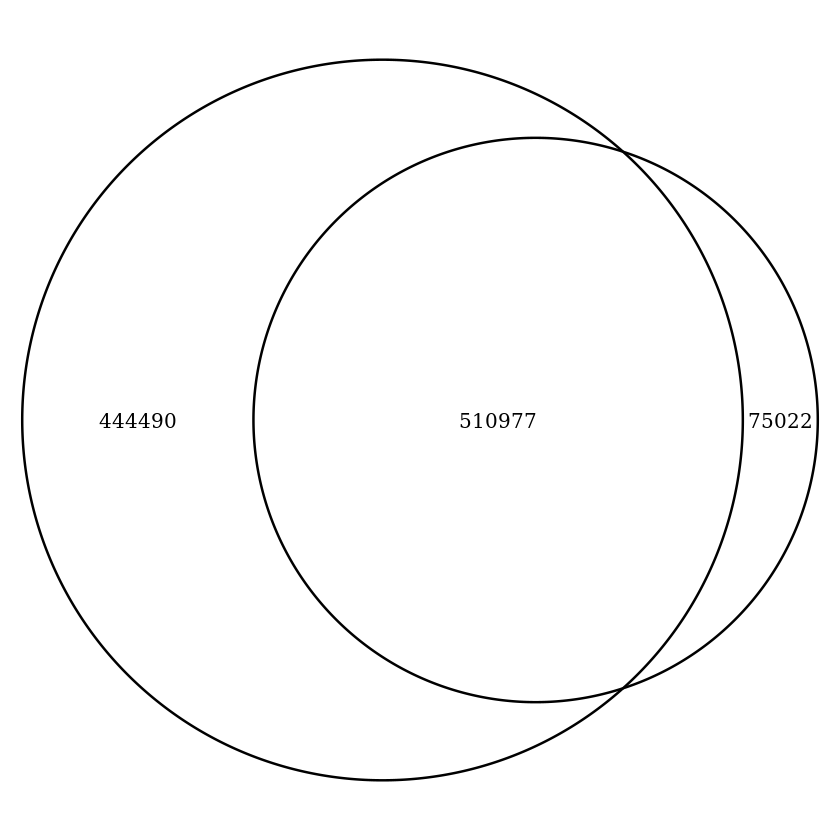

In [8]:
# join DM and BS min methylation means by chromosome and bin
cor_data_bin <- inner_join(DM_bin_1000_mean_20b,BS_bin_1000_mean_20b,by=c("chr","bin_1000"))

#this plot shows unique 1 kB bins filtered for 20 CpGs for both datasets.
grid.newpage()
draw.pairwise.venn(area1 = nrow(BS_bin_1000_mean_20b), 
                  area2 = nrow(DM_bin_1000_mean_20b), 
                  cross.area = nrow(cor_data_bin))

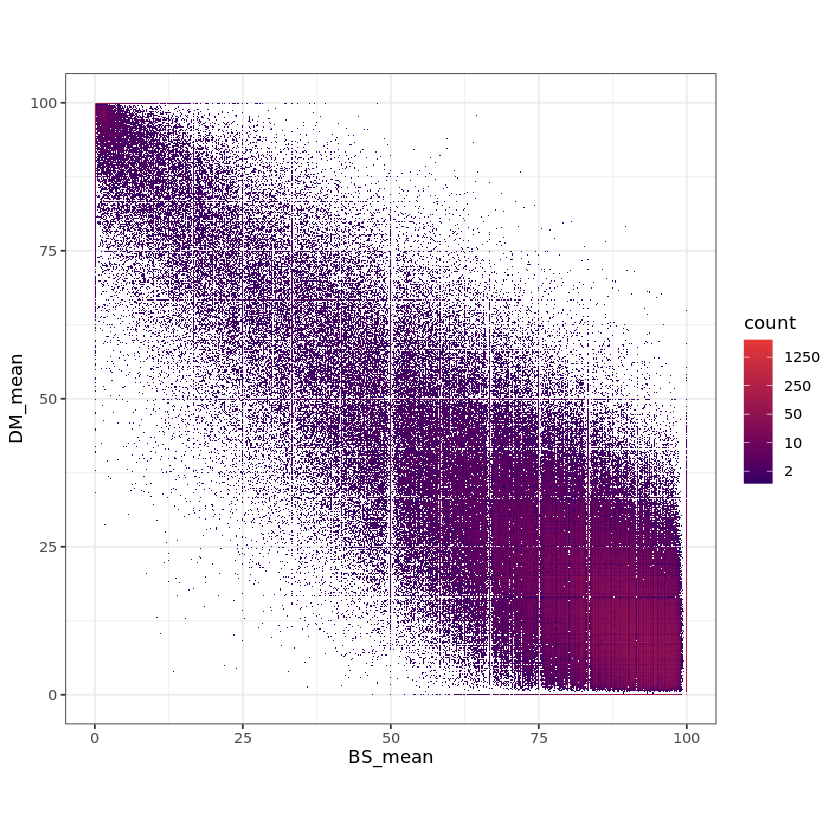

In [9]:
# create plot
# x axis is average % cytosine in BS-seq
# y axis is average % cytosine in DM-seq

my_breaks = c(2,10,50,250,1250)

p <- ggplot(cor_data_1000_20b, aes(x=BS_mean,y=DM_mean)) + 
geom_bin_2d(bins = 500) + 
theme_bw() + theme(aspect.ratio = 1) + 
scale_fill_gradient(name = "count", trans = "log", high = "#E53935", low = "#330066",
                        breaks = my_breaks, labels = my_breaks)

p 

In [10]:
cor(cor_data_1000_20b$BS_mean,cor_data_1000_20b$DM_mean)

[1] -0.8800205

# Figure 4C

Genomic elements were defined as follows: exons and introns: UCSC RefGene for genome build hg19. Promoters: +/- 1kb from the transcription start site. Active promoters: H3K4me3 ChIP-Seq performed on glioblastoma stem cells (GSM3357599). Enhancers: Non-promoter regions with a H3K27Ac ChIP-Seq signal (GSM1306369).

bedtools was then used to intersect BS or DM coverage files with each genomic element.

bedtools intersect -a {sample}.bismark.cov - b {element}.bed -wa -wb > {output}.bed

A master bedfile containing data from every genomic element is read and wrangled as below.

In [11]:
# used bedtools intersect and genome 
file_BS <- read.csv('GBM_BS_all_elements.bed',header=FALSE,sep='\t')
file_DM <- read.csv('GBM_DM_all_elements.bed',header=FALSE,sep='\t')

# convert to dataframes for easier manipulation
data_BS <- tbl_df(file_BS)
data_DM <- tbl_df(file_DM)

# rename columns
data_BS <- data_BS %>% rename(chrA=V1,startA=V2,endA=V3,perc_methyl=V4,count_C=V5,count_T=V6,chrmB=V7,startB=V8,endB=V9,element=V10)
data_DM <- data_DM %>% rename(chrA=V1,startA=V2,endA=V3,perc_methyl=V4,count_C=V5,count_T=V6,chrmB=V7,startB=V8,endB=V9,element=V10)

# create new column that combines start and end of element = element bin variable
data_BS <- data_BS %>% mutate(element_bin = paste(startB, endB, sep=','))
data_DM <- data_DM %>% mutate(element_bin = paste(startB, endB, sep=','))

# summarize count C and count T by element bin
data_BS <- data_BS %>% group_by(chrmB,element,element_bin) %>% mutate(total_C_element_bin = sum(count_C),
                                                                     total_T_element_bin = sum(count_T))
data_DM <- data_DM %>% group_by(chrmB,element,element_bin) %>% mutate(total_C_element_bin = sum(count_C),
                                                                     total_T_element_bin = sum(count_T))

# calculate % modification for element bin
data_BS <- data_BS %>% mutate(perc_mod_element= (total_C_element_bin / (total_C_element_bin + total_T_element_bin))*100)
data_DM <- data_DM %>% mutate(perc_mod_element= (total_T_element_bin / (total_C_element_bin + total_T_element_bin))*100)

# add experiment identifier column
data_BS <- data_BS %>% mutate(exp='BS')
data_DM <- data_DM %>% mutate(exp='DM')


In [12]:
# collapse into element bins, summarizing mean modification in elemental bin
data_BS_sum <- data_BS %>% group_by(chrmB,element,element_bin) %>% summarise(mean_mod_element=mean(perc_mod_element))

data_DM_sum <- data_DM %>% group_by(chrmB,element,element_bin) %>% summarise(mean_mod_element=mean(perc_mod_element))

# add experiment identifier to summary dataframe
data_BS_sum <- data_BS_sum %>% mutate(exp='BS')
data_DM_sum <- data_DM_sum %>% mutate(exp='DM')

# combine BS and DM data
data_summary <- bind_rows(data_BS_sum,data_DM_sum)

# remove elements we don't want to plot
data_2 <- data_summary %>% filter(element != "H3K27me3")
data_2 <- data_2 %>% filter(element != "intergenic")

`summarise()` has grouped output by 'chrmB', 'element'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'chrmB', 'element'. You can override using the `.groups` argument.


Warning message:
“`fun.y` is deprecated. Use `fun` instead.”Warning message:
“`fun.y` is deprecated. Use `fun` instead.”

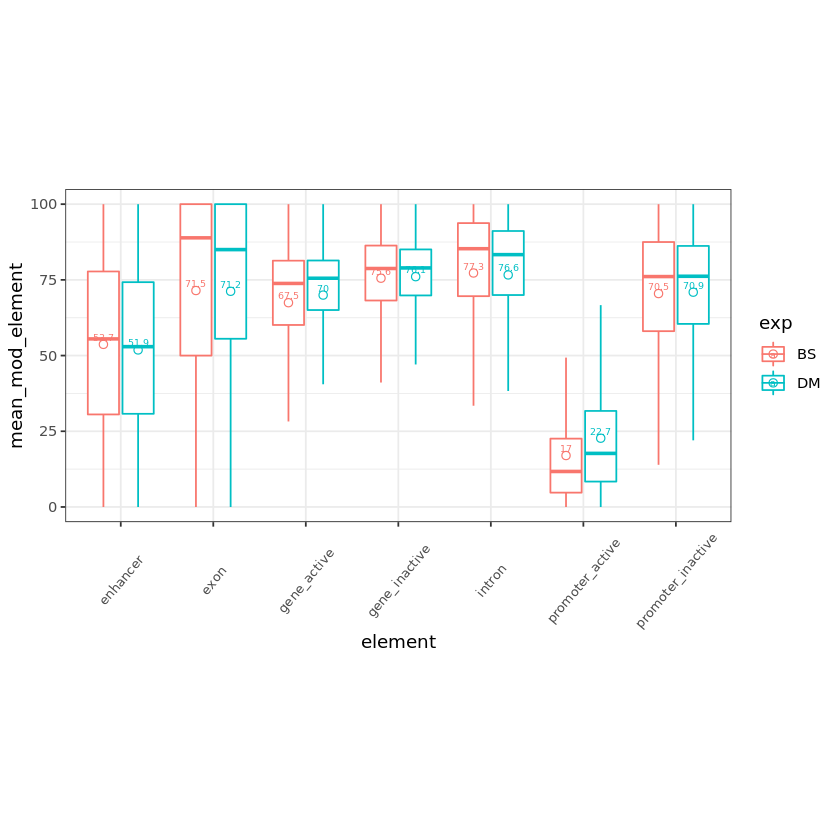

In [13]:
# plot and save boxplot with labels of mean values
p <- ggplot(data_2,aes(x=element,y=mean_mod_element)) + 
geom_boxplot(outlier.shape=NA, aes(color = exp)) +
  stat_summary(
    aes(color = exp),
    geom = "point",
    fun.y = "mean",
    position = position_dodge(0.75),
    size = 2,
    shape = 1
  ) +
stat_summary(aes(label=round(..y..,1), color = exp), fun.y=mean, 
             geom="text", size=2, position = position_dodge(0.75),
             vjust = -0.5) +
theme_bw() + 
theme(axis.text.x=element_text(angle=50,size=8,vjust=0.5)) + 
theme(aspect.ratio=0.5)

p

# 4D

Used [deepTools](https://deeptools.readthedocs.io/en/develop/content/list_of_tools.html) to generate heatmaps.

Got H3K4me3 bigWig file from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3357599

Got the whole gene reference file from: https://genome.ucsc.edu/cgi-bin/hgTables?hgsid=1209187389_a3wgyAcF7Ml2Waxca584dNwlEwmD&clade=mammal&org=Human&db=hg19&hgta_group=genes&hgta_track=refSeqComposite&hgta_table=refGene&hgta_regionType=genome&position=chrX%3A15%2C578%2C261-15%2C621%2C068&hgta_outputType=gff&hgta_outFileName=cov
* output format = BED - browser extensible data
* otherwise everything the same as it opens up

`computeMatrix scale-regions -S {H3K4me3}.bw {DM-Seq}.bw {BS_Seq}.bw -R {RefGene}-sort.bed -m 10000 -b 5000 -a 5000 -bs 500 -p "max/2" -o {matrix}.tab.gz`

Data with NAs were removed.

`plotHeatmap -m H3K4me3_DM_BS_scaled.m10k.ab5k.bs500-noNA.tab.gz -out H3K4me3_DM_BS_scaled.m10k.ab5k.bs500-noNA_sortmax.pdf --missingDataColor .4 --heatmapHeight 20 --heatmapWidth 7 --plotTitle "sort with H3K4me3 max, all genes, bs = 500" --whatToShow 'heatmap and colorbar' --sortRegions ascend --sortUsing max --samplesLabel H3K4me3 DM BS --sortUsingSamples 1 --colorMap Greys inferno inferno --plotFileFormat 'pdf'`

# 4E, E10, STable 4

Figure 4E shows how we compared the ability of DM-Seq and BS-Seq to uncover "true 5mC" signal at sites that were already thought to be enriched in 5-hydroxymethylcytosine (5hmC) in the glioblastoma tumor type. The wrangling performed here is presented across Supplementary Table 4, Extended Data Figure 10, and Figure 4E. It is easiest to sequentially follow how this data was generated by first looking at Supplementary Table 4.

In [14]:
#calculate mean of total BS and DM Seq datasets.
BS_mean <- sum(BS_cov_df$V5) / (sum(BS_cov_df$V5) + sum(BS_cov_df$V6))
DM_mean <- sum(DM_cov_df$V6) / (sum(DM_cov_df$V5) + sum(DM_cov_df$V6))

#coverage
nrow(BS_cov_df)
nrow(DM_cov_df)

#these values are reported in the first rows of Supp Table 4.

[1] 25138620

[1] 30369633

Extrapolation in Extended Data Figure 10c was calculated by dividing the unique BS CpGs by the ratio of the input volumes for the pooled NextSeq sample (0.55/0.26):

(2.51e7) / (0.55/0.26) = 1.19e7

In [15]:
#percent modification
BS_mean 
DM_mean
#these values are reported in the second row of Supp Table 4.

[1] 0.7444796

[1] 0.7586793

In [16]:
#compute coverage and mean for just the shared CpGs between DM-Seq and BS-Seq 
#combine
all_cpgs <- inner_join(BS_cov_df, DM_cov_df, by = c("chr","start"))
all_cpgs <- all_cpgs %>% ungroup()
nrow(all_cpgs) #number of cpgs shared between the two datasets

BS_mean_join <- sum(all_cpgs$V5.x) / (sum(all_cpgs$V5.x) + sum(all_cpgs$V6.x)) #BS mean inner_join
DM_mean_join <- sum(all_cpgs$V6.y) / (sum(all_cpgs$V5.y) + sum(all_cpgs$V6.y)) #DM mean inner_join

#percent modification
BS_mean_join
DM_mean_join

#these values are reported in the third and fourth rows of Supp Table 4.

[1] 16438445

[1] 0.7595618

[1] 0.7540069

The 3,876 “high 5hmC” CpG sites were previously defined identified by OxBS-Seq and used to calculate percent modification by both BS-Seq and DM-Seq (Johnson et al. Nat. Commun. 2016. 10.1038/ncomms13177, Supp. Data 1). DM-Seq and BS-Seq signals could be determined at these CpGs. 



In [17]:
#read high 5hmC CpG file
file_high_5hmC <- read.csv('high_5hmC_cpgs.csv',header=TRUE,sep=',')
data_high_5hmC <- tbl_df(file_high_5hmC)

In [18]:
#create a column in the correct syntax so as to use for joining later
data_BS <- BS_cov_df %>% mutate(chrA_startA = paste(chr, start, sep = '_'))
data_DM <- DM_cov_df %>% mutate(chrA_startA = paste(chr, start, sep = '_'))

In [19]:
#create a column in the correct syntax so as to use for joining later
data_high_5hmC <- data_high_5hmC %>% mutate(A_startA = paste(chrA, startA, sep = '_'))

#add on the chr label to match the DM-Seq/BS-Seq syntax
data_high_5hmC <- data_high_5hmC %>% mutate(chrA_startA = paste('chr', A_startA, sep = ''))

In [20]:
#bind data by the chromosome + cpg location
data_join_BS <- inner_join(data_BS,data_high_5hmC, by = "chrA_startA")
data_join_DM <- inner_join(data_DM,data_high_5hmC, by = "chrA_startA")

#compute number of CpGs as well as % modification observed for BS
nrow(data_join_BS)
sum(data_join_BS$V5) / (sum(data_join_BS$V5) + sum(data_join_BS$V6))

#compute number of CpGs as well as % modification observed for DM
nrow(data_join_DM)
sum(data_join_DM$V6) / (sum(data_join_DM$V5) + sum(data_join_DM$V6))

#This data is displayed in Supplementary Table 4, Rows 5 and 6

[1] 2132

[1] 0.7502284

[1] 2538

[1] 0.6285398

In [21]:
#find the overlap of high 5hmCs, BS-Seq, and DM-Seq
data_join_intersect <- inner_join(data_join_BS, data_join_DM, by = "chrA_startA")
nrow(data_join_intersect)
#this value is displayed in Supplementary Table 4, row 7.

[1] 1485

In [22]:
#compute the percent modification in BS-Seq and DM-Seq datasets

#BS intersect only
BS_obs <- sum(data_join_intersect$V5.x) / (sum(data_join_intersect$V5.x)+sum(data_join_intersect$V6.x))
BS_obs

#DM intersect only
DM_obs <- sum(data_join_intersect$V6.y) / (sum(data_join_intersect$V5.y)+sum(data_join_intersect$V6.y))
DM_obs

#this value is displayed in Supplementary Table 4, row 8

#difference between BS-Seq and DM-Seq
diff <- sum(data_join_intersect$V5.x) / (sum(data_join_intersect$V5.x)+sum(data_join_intersect$V6.x)) - sum(data_join_intersect$V6.y) / (sum(data_join_intersect$V5.y)+sum(data_join_intersect$V6.y))
diff

[1] 0.7560976

[1] 0.6135371

[1] 0.1425604

In [23]:
k = 10000 #number of times to plot, row 9 Supplementary Table 4
j = 1485 #number of cpgs, row 10 Supplementary Table 4

In [24]:
#create downsampled dataset
down_cpgs <- sample_n(all_cpgs,j)

#seed
i=0

#loop to do downsampling "simulations"
#each loop will randomly sample 1485 total CpGs from the BS and DM Seq datasets
#to report what is the observed percent modification at these 1485 random CpGs
while (i < k)
    {
name <- paste("cpgs",i, sep="_")
    set.seed(i)
    new_cpgs <- sample_n(all_cpgs, j)
    new_cpgs <- new_cpgs %>% mutate (simulation = i)
    down_cpgs <- bind_rows(down_cpgs, new_cpgs)
    i = i+1
}

#remove nas
down_cpgs <- na.omit(down_cpgs)

#compute percent modification with every simulation
down_cpgs <- down_cpgs %>% group_by (simulation) %>% mutate(percent_BS = sum(V5.x) / (sum(V5.x + V6.x)))
down_cpgs <- down_cpgs %>% group_by (simulation) %>% mutate(percent_DM = sum(V6.y) / (sum(V5.y + V6.y)))

In [25]:
#collapse data to only have one data point per simulation
summary <- down_cpgs %>% group_by(simulation) %>% filter(row_number()==1)
nrow(down_cpgs) #full datafile has rows equal to the number simulations x number of cpgs (10k x 1485)
nrow(summary) #summary datafile only has simulations for the number of rows (10k).

[1] 14850000

[1] 10000

In [26]:
#simplify data frame
summary_2 <- summary %>% select (simulation,percent_BS,percent_DM)

#compute values for SIMULATED CpGs
#these values are reported in the last two rows of Supplementary Table 10
mean(summary_2$percent_BS)
mean(summary_2$percent_DM)
sd(summary_2$percent_BS)
sd(summary_2$percent_DM)

[1] 0.7595761

[1] 0.7541192

[1] 0.01135859

[1] 0.01057883

In [27]:
#diff downsamplings
diff_down <- mean(summary_2$percent_DM) - sum(data_join_intersect$V6.y) / (sum(data_join_intersect$V5.y)+sum(data_join_intersect$V6.y))
diff_down

#number of stdevs two methods
#this number is reported in the Figure 4E
diff_down / sd(summary_2$percent_DM)

[1] 0.1405821

[1] 13.28901

(polygon[GRID.polygon.265], polygon[GRID.polygon.266], polygon[GRID.polygon.267], polygon[GRID.polygon.268], text[GRID.text.269], text[GRID.text.270], text[GRID.text.271], text[GRID.text.272], text[GRID.text.273]) 

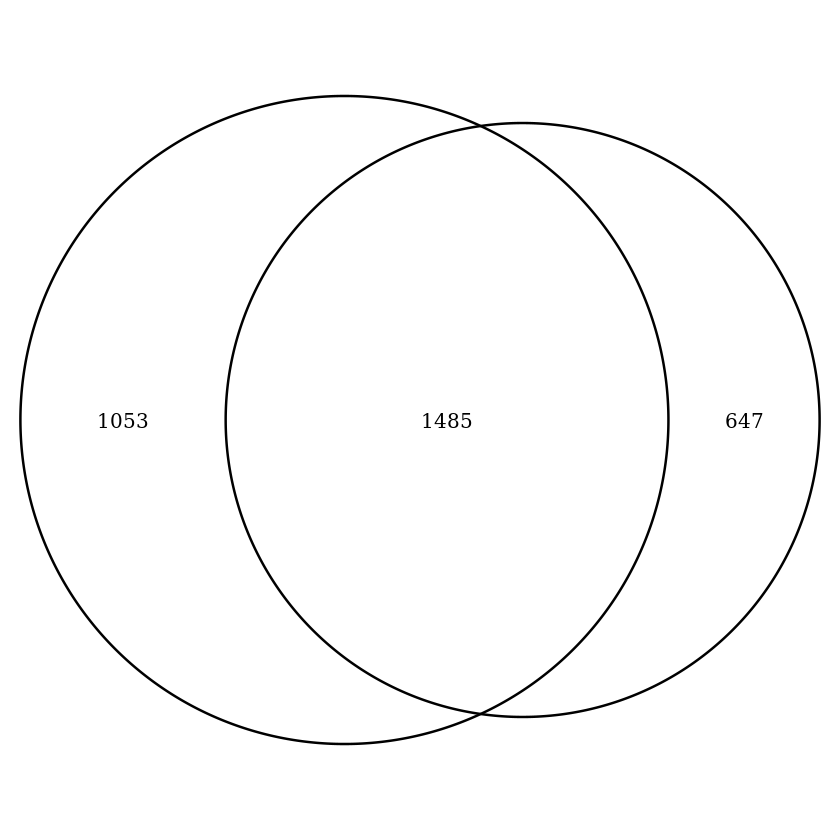

In [28]:
#Extended Data 10D
grid.newpage()
draw.pairwise.venn(area1 = nrow(data_join_BS), 
                  area2 = nrow(data_join_DM), 
                  cross.area = nrow(data_join_intersect))

#the values reported in this Figure have all been generated in Supplementary Table 10 
#except for the one shown below.

In [29]:
data_join_BS_DM <- full_join(data_BS,data_DM, by = "chrA_startA")
data_join_BS_DM_5hmC <- inner_join(data_join_BS_DM,data_high_5hmC, by = "chrA_startA")
nrow(data_join_BS_DM_5hmC) #reports number of CpGs covered by either dataset, reported in Supplementary Figure 10D

[1] 3185

In [30]:
#rearrange (gather) data frame
summary_gather <- summary_2 %>% gather("exp", "percent", 2:3)
head(summary_gather)


simulation,exp,percent
0,percent_BS,0.7405999
1,percent_BS,0.7545613
2,percent_BS,0.7760239
3,percent_BS,0.7785558
4,percent_BS,0.7560345
5,percent_BS,0.7534783


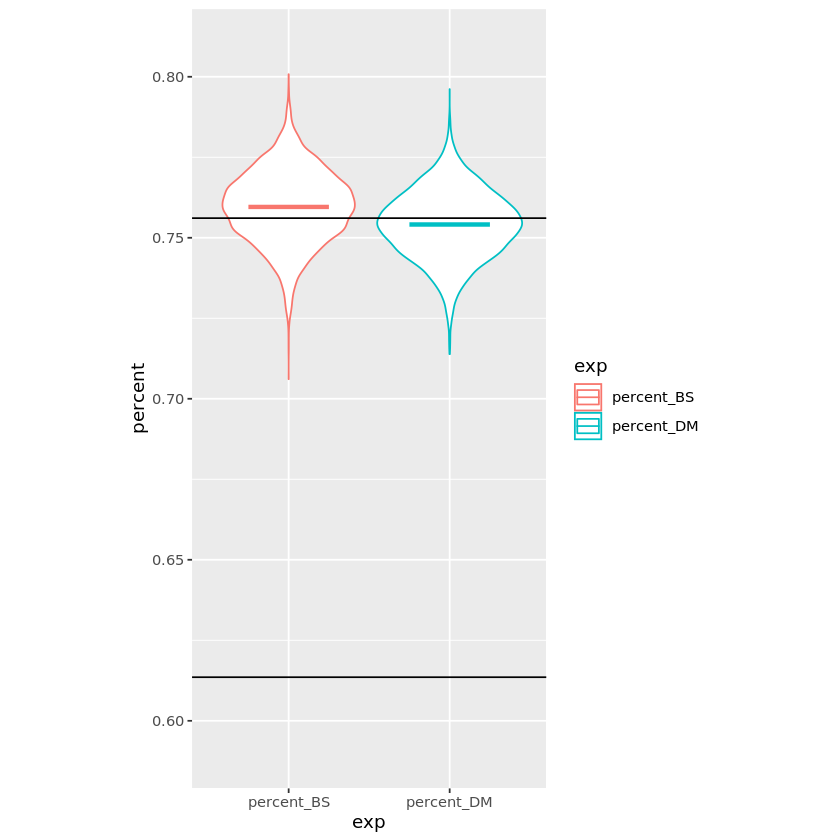

In [31]:
#Visualize the downsampled data in Figure 4E
p <- ggplot(summary_gather, aes(x = exp, y = percent, color = exp)) + 
geom_violin() + 
stat_summary(fun = "mean",
               geom = "crossbar", 
               width = 0.5) + 
ylim(.59,.81) + coord_fixed(ratio=20) + scale_x_discrete(limits = rev(levels(exp))) +
geom_hline(yintercept=BS_obs) + geom_hline(yintercept=DM_obs) #shows location of observed values, difficult to plot in ggplot

p